In [1]:
import altair as alt
import pandas as pd
import re

# Altair plots render by default in JupyterLab and nteract
# Uncomment/run this line to enable Altair in the classic notebook (not in JupyterLab)
a= alt.renderers.enable('notebook')
blogs = pd.read_csv('blogtext.csv') # Cargar base de datos

# Análisis trafico Imagenes

Al revisar los datos es posible encontrarse con entradas de texto como la que se ve a continuacion: 

In [2]:
blogs.loc[97,'text']

'                 http://www.uploadimages.net/images/648898PICT0074.JPG  http://www.uploadimages.net/images/789165PICT0037.JPG  http://www.uploadimages.net/images/456053PICT0066.JPG my shoes travel far and wide  http://www.uploadimages.net/images/322394PICT0096.JPG one day i will look nice in a pic  http://www.uploadimages.net/images/149883PICT0026.JPG banana phone!!!  i hav loads more but will put em on a site or somit later,  ~Disturbed Angel - Beautifully Decayed~      '

Las direcciones ``http:`` que se ven en el texto corresponden a paginas para hostear imagenes. Sabiendo esto, se buscó analizar el numero de imagenes que son referenciadas en las entradas de los blogs, en relacion con la fecha en la fueron subidas. Se espera encontrar patrones como que por ejemplo, en verano se referencien mas fotos que en invierno.

## Procedimiento:

### 1. 
Se crearon las siguientes funciones para poder filtrar la informacion. Primero se busca remover todo el texto que no sea parte de una direccion ``http:`` y luego buscar cuales de estos links referencian directamente a una imagen.

In [3]:
# Entrega una LISTA con las direcciones url que encuentra en el bloque de texto
def Find_url(string): 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
    return url 

# Entrega una LISTA con las Imagenes que encuentra en el bloque de texto
def Find_img(string):
    img = re.findall('.jpg|.JPG|.png|.PNG|.jpeg|.JPEG|.TIF', string)
    if len(img) == 0:
        img = re.findall('/photos', string)
    return img

# Cuenta el numero de imagenes encontradas
def Conteo(string):
    return len(Find_img(string))

# Convierte las listas de Find_url en un STRING
def Links(string):
    if len(Find_url(string)) == 0:
        return 'No hay links'
    else:
        fullStr = '-'.join(Find_url(string))
        return fullStr
    
# Convierte las listas de Find_img en un STRING
def Imagenes(string):
    if len(Find_img(string)) == 0:
        return 'No hay imagenes'
    else:
        fullStr2 = '-'.join(Find_img(string))
        return fullStr2

### 2. 
Se filtra lo que no sea url.

In [4]:
blogs_con_links = blogs['text'].apply(Links) 
blogs_con_links =(blogs_con_links[blogs_con_links != "No hay links"]) #Eliminar filas sin links
blogs_con_links.head()

2                            http://my.ohio.voyager.net/
97     http://www.uploadimages.net/images/648898PICT0...
172    http://www.bewitched.com/m/    urlLink http://...
191    http://www.amishdonkey.com/weeee.php   don't c...
195    http://www.lacunacoil.it/etc/html/eng/index.ht...
Name: text, dtype: object

### 3. 
Se hace el conteo de cuantas imagenes hay en cada entrada.

In [5]:
Imgs_en_blog = blogs_con_links.apply(Imagenes)
Imgs_en_blog =(Imgs_en_blog[Imgs_en_blog != 'No hay imagenes']) #Eliminar filas sin imagenes
Imgs_en_blog = Imgs_en_blog.apply(Conteo) #Contar Imagenes por entrada
Imgs_en_blog.head()

97      5
3546    1
3870    1
8676    1
8698    1
Name: text, dtype: int64

### 4. 
Se juntan en un ``dataframe`` la fecha de la entrada con el conteo.

In [6]:
max_filas = len(Imgs_en_blog) 

# Dataframe con la fecha y el conteo de imagenes de la entrada
conteo_con_fecha = pd.DataFrame(index=range(0,max_filas),columns=['Fecha','Imagenes'], dtype='float') #df vacio
for i in range(0,max_filas):
    conteo_con_fecha.iloc[ i , 1] = Imgs_en_blog.iloc[i]
    pos_fila = Imgs_en_blog.index[i] 
    conteo_con_fecha.iloc[ i , 0] = blogs.iloc[pos_fila, 5]

conteo_con_fecha.head()

,Fecha,Imagenes
0,"30,June,2004",5.0
1,"05,August,2004",1.0
2,"03,June,2003",1.0
3,"10,August,2004",1.0
4,"10,August,2004",1.0


## Grafica 1

En la primera grafica se puede ver el rapido crecimiento que tiene el numero de imagenes dentro de las entradas de los blogs. Esto tiene sentido teniendo en cuenta que, durante esos años la fotografia digital tuvo un crecimiento acelerado, y era cadavez mas accequible al publico.

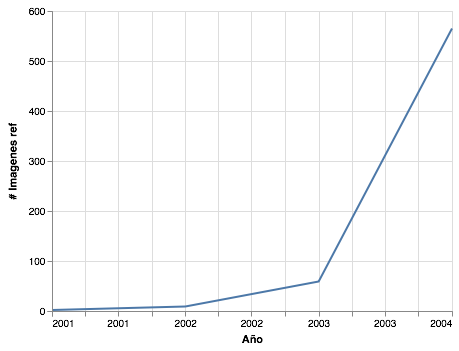

In [7]:

# Eliminacion errores puntuales en to_datetime                                    
conteo_con_fecha =(conteo_con_fecha[conteo_con_fecha['Fecha']!='01,Agosto,2004'])
conteo_con_fecha =(conteo_con_fecha[conteo_con_fecha['Fecha']!='03,Juni,2004'])
conteo_con_fecha =(conteo_con_fecha[conteo_con_fecha['Fecha']!='20,giugno,2004'])
conteo_con_fecha =(conteo_con_fecha[conteo_con_fecha['Fecha']!='21,avril,2004'])
conteo_con_fecha =(conteo_con_fecha[conteo_con_fecha['Fecha']!='01,janvier,2004'])
conteo_con_fecha =(conteo_con_fecha[conteo_con_fecha['Fecha']!='15,julio,2004'])

# Se convierte la fecha al formato de pandas
conteo_con_fecha['Fecha'] =  pd.to_datetime(conteo_con_fecha['Fecha'])

# Grafica cambio anual
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(conteo_con_fecha).mark_line().encode(
    x=alt.X('Fecha:T', timeUnit='year',title='Año'),
    y=alt.Y('sum(Imagenes):Q',title='# Imagenes ref')
)

## Grafica 2

la informacion obtenida no permite encontrar un patron mensual, esto tambien es causado en parte por el rapido crecimiento anual que tiene. la siguiente grafica muestra una version ampliada de esta grafica.

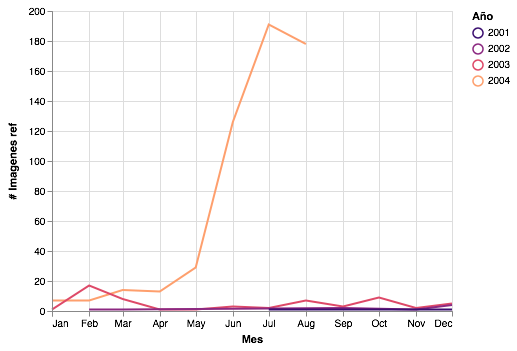

In [8]:
#Grafica cambio mensual
alt.Chart(conteo_con_fecha).mark_line().encode(
    x=alt.X('Fecha:T', timeUnit='month',title='Mes'),
    y=alt.Y('sum(Imagenes):Q', scale=alt.Scale(clamp = True, domain=(0,200)),title='# Imagenes ref'),
    color =alt.Color('Fecha:O', timeUnit='year', scale=alt.Scale(scheme='magma'),title='Año')
)

## Grafica 2 (ZOOM)

Al acercarse se puede ver que el comportamiento mensual no sigue un patron evidente.

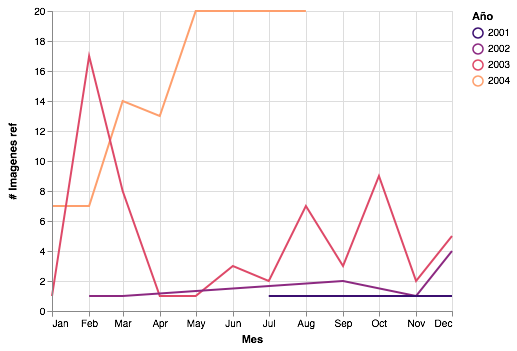

In [9]:
# Zoom en la grafica cambio mensual
alt.Chart(conteo_con_fecha).mark_line().encode(
    x=alt.X('Fecha:T', timeUnit='month',title='Mes'),
    y=alt.Y('sum(Imagenes):Q', scale=alt.Scale(clamp = True, domain=(0,20)),title='# Imagenes ref'),
    color =alt.Color('Fecha:O', timeUnit='year', scale=alt.Scale(scheme='magma'),title='Año')
)

# Ejemplos texto con referencias a imagenes

In [10]:
blogs.loc[679741,'text']

"       Here's a link to a photo from earlier today after the haircut, enjoy!  urlLink http://www.backslider.net/gallery/photos/DSCN1638           "

In [11]:
blogs.loc[97,'text']

'                 http://www.uploadimages.net/images/648898PICT0074.JPG  http://www.uploadimages.net/images/789165PICT0037.JPG  http://www.uploadimages.net/images/456053PICT0066.JPG my shoes travel far and wide  http://www.uploadimages.net/images/322394PICT0096.JPG one day i will look nice in a pic  http://www.uploadimages.net/images/149883PICT0026.JPG banana phone!!!  i hav loads more but will put em on a site or somit later,  ~Disturbed Angel - Beautifully Decayed~      '

In [12]:
blogs.loc[20341,'text']

"       Hey everyone I'm back but I'm going to be leaving tomorrow to Houstan Texas. I've decided to probly just leave the blog to you guys but I want some feed back on these picture I drew.  Person:  urlLink http://www.imageuploader.net/images/265859Picture.jpg  Person with Face:  urlLink http://www.imageuploader.net/images/762143Person(Done).jpg  Final Person:  urlLink http://www.imageuploader.net/images/615277Person+Path(No_Weapons).JPG  Cloak:  urlLink http://www.imageuploader.net/images/801122Cloak(Shaded).jpg  Cloack+Weapons:  urlLink http://www.imageuploader.net/images/604654Cloak+Sword+Shield.jpg   I'm bored so I'm going to stop now...Bye everyone!          "